In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading in the extracted, normalized, binned spectral light curves
## from my 'Extracting the Transmission Spectra time series' notebook
tsdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/normalizedSpectralTimeSeries.npz')
times = tsdata['times']
fluxes = tsdata['fluxes']
errors = tsdata['errors']
waves = tsdata['wavelengths']

In [3]:
Npoints = fluxes.shape[0]
Nwaves = fluxes.shape[1]

In [4]:
##
# Defining my parameter arrays (inits, priors, etc)
# I'll fix all of the orbital parameters to values gotten from my broadband fitting
# Here, I'll only fit the transit depths and systematic parameters
# I should also look into using single systematics based on broadband fitting too
rprs_init, rprs_init_unc = 0.0439177, 0.00027693

t0_fixed = 2458329.202196752
P_fixed = 6.03448
a_fixed = 13.4136
inc_fixed = 86.438
ecc_fixed = 0.
w_fixed = 90.
u_fixed = [0.33, 0.2]

amplitude_o2_init, amperr_o2_init = 0.00176025, 3.18044e-5
amplitude_o3_init, amperr_o3_init = 0.00146294, 3.27505e-5
amplitude_o4_init, amperr_o4_init = 0.00167732, 2.94116e-5
    
tau_o2_init, tauerr_o2_init = 0.0042273, 0.00012699
tau_o3_init, tauerr_o3_init = 0.00470822, 0.00024072
tau_o4_init, tauerr_o4_init = 0.0078746, 0.00024142

theta_rprs = np.asarray([rprs_init]*Nwaves)
theta_amps = np.asarray([amplitude_o2_init, amplitude_o3_init, amplitude_o4_init]*Nwaves)
theta_taus = np.asarray([tau_o2_init, tau_o3_init, tau_o4_init]*Nwaves)
theta_init = np.concatenate((theta_rprs, theta_amps, theta_taus))

priorerrs_rprs = np.asarray([rprs_init_unc]*Nwaves)
priorerrs_amps = np.asarray([amperr_o2_init, amperr_o3_init, amperr_o4_init]*Nwaves)
priorerrs_taus = np.asarray([tauerr_o2_init, tauerr_o3_init, tauerr_o4_init]*Nwaves)
priorerrs = np.concatenate((priorerrs_rprs, priorerrs_amps, priorerrs_taus))

In [5]:
# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = t0_fixed     
InitParams.per = P_fixed
InitParams.a = a_fixed
InitParams.inc = inc_fixed
InitParams.rp = rprs_init
InitParams.ecc = ecc_fixed
InitParams.w = w_fixed
InitParams.limb_dark = 'quadratic'
InitParams.u = u_fixed
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [6]:
##
# Defining my astrophysical models

def transit(rprs, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = t0_fixed       # time of conjunction [days]
    P = P_fixed  # compute Period in [day]
    a = a_fixed  # compute a/Rstar
    inc = inc_fixed  # Compute inclination in [deg]
    ecc = ecc_fixed    # use these if assuming circular orbit
    omega = w_fixed
    rprstar = rprs
        
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = u_fixed
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve


##
# Defining my systematic models
def hook(params):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude_o2 = params[0]
    amplitude_o3 = params[1]
    amplitude_o4 = params[2]
    
    tau_o2 = params[3]
    tau_o3 = params[4]
    tau_o4 = params[5]
    
    # Pull out times [in day; MJD] of each orbit
    orbit_ends = np.array([17, 34, 51])
    orbit2times = times[:orbit_ends[0]]
    orbit3times = times[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times[orbit_ends[1] : orbit_ends[2]]
    
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    
    orbit2hook = 1.0 - amplitude_o2*np.exp(- tinorbit2 / tau_o2)
    orbit3hook = 1.0 - amplitude_o3*np.exp(- tinorbit3 / tau_o3)
    orbit4hook = 1.0 - amplitude_o4*np.exp(- tinorbit4 / tau_o4)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve

In [7]:
def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

def lnPosterior(theta):
    
#     prior_array = priors
#     priorerrs_array = priorserr
    flux_array = fluxes
    unc_array = errors
    Nwavs = flux_array.shape[1]
    
    total_lnLikelihood = 0.
    for wav in range(Nwavs):
        lcflux = flux_array[:,wav]
        lcerrs = unc_array[:,wav]
        wav_rprs = theta[wav]
        
        wav_transit = transit(wav_rprs, BATMAN_initmodel)

        wav_params = theta[Nwavs+(6*wav): Nwavs+(6*wav)+6]
        wav_hook = hook(wav_params)
        wav_model = wav_transit * wav_hook
        
        wav_likelihood = logLikelihood(lcflux, lcerrs, wav_model)
        total_lnLikelihood += wav_likelihood
    
#     # Compute and check priors
#     lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
#     if not np.isfinite(lnPrior_value):
#         return -np.inf

    # Compute posterior
    lnPost = total_lnLikelihood
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

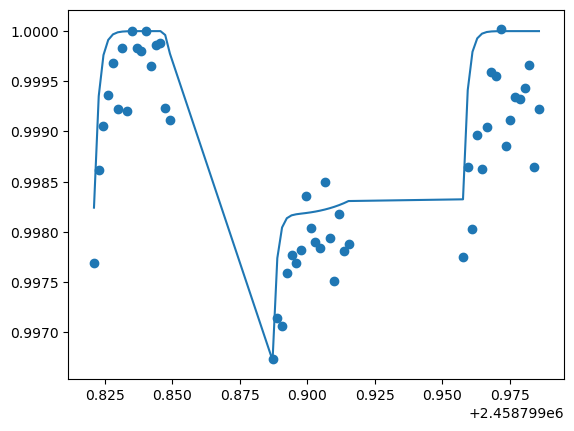

In [8]:
tmodel_test = transit(theta_rprs[3], BATMAN_initmodel)
hookmodel_test = hook(theta_init[Nwaves:Nwaves+6])
model_test = tmodel_test * hookmodel_test
plt.plot(times, model_test)
plt.scatter(times, fluxes[:,3])
plt.show()

In [9]:
lnPost_init = lnPosterior(theta_init)
print(lnPost_init)

-25409.264689108884


In [30]:
######################################
# Setting up and initializing MCMC
Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions
Nsteps = 20000

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

try:
    # if I stored previous run's fit values, initialize based on those
    %store -r tspec_paramfits
    %store -r tspec_paramerrs
    for i in range(Ndimensions):
        pos[:,i] = tspec_paramfits[i] + 0.5*np.random.normal(0., tspec_paramerrs[i], Nwalkers)
    print('Walkers generated using stored variables')
except:
    try:
        # if we ran this before, initialize based on previous run's best fits
        for i in range(Ndimensions):
            pos[:,i] = param_fits[i] + 0.5*np.random.normal(0., param_uperrs[i], Nwalkers)
        print('Walkers generated using param_fits')
    except:
        # if not, then use theta_init array
        for i in range(Ndimensions):
            pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorerrs[i], Nwalkers)
        print('Walkers generated using theta_init')
    


Walkers generated using stored variables


In [31]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 20000/20000 [11:46<00:00, 28.31it/s]


In [32]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()

burn = 1000
samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

In [36]:
storeVals = True
if storeVals:
    tspec_paramfits = np.copy(param_fits)
    tspec_paramerrs = np.copy(param_uperrs)
    %store tspec_paramfits
    %store tspec_paramerrs

Stored 'tspec_paramfits' (ndarray)
Stored 'tspec_paramerrs' (ndarray)


In [13]:
# fig, axes = plt.subplots(samples.shape[2], figsize=(14,35), sharex=True)
# for i in range(samples.shape[2]):
#     ax = axes[i]
#     ax.plot(samples[:,:,i], "k", alpha=0.3)
#     ax.set_xlim(0, len(samples))
#     ax.set_ylabel(i)
    
    
# axes[0].set_title('Parameter Chains with %d step burn-in and %d total steps'%(burn, Nsteps))
# axes[-1].set_xlabel('Steps')
# #plt.savefig('figures/HSTbroadbandfit_chains.png', dpi=300, bbox_inches='tight')
# plt.show()

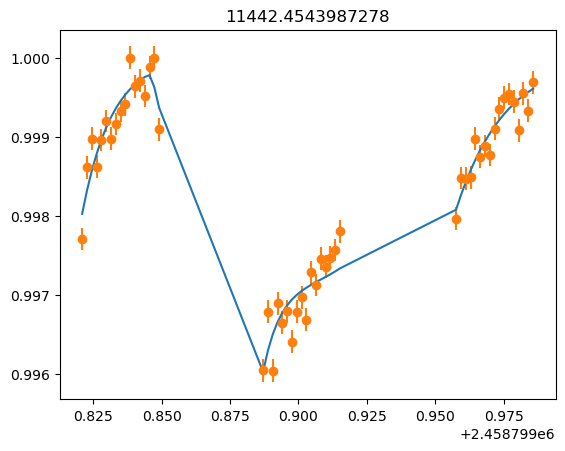

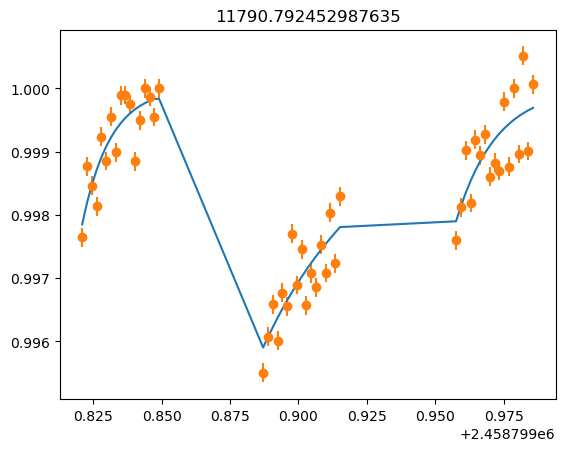

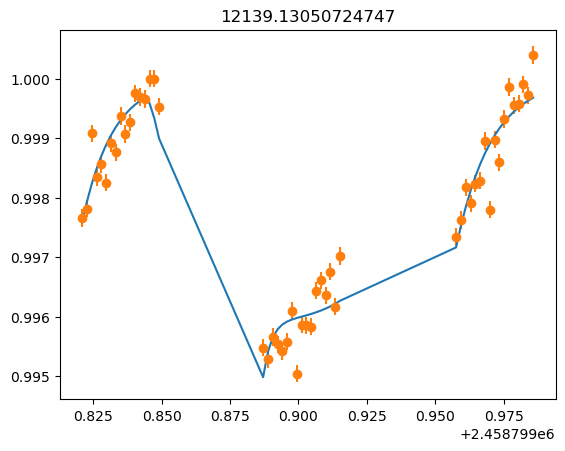

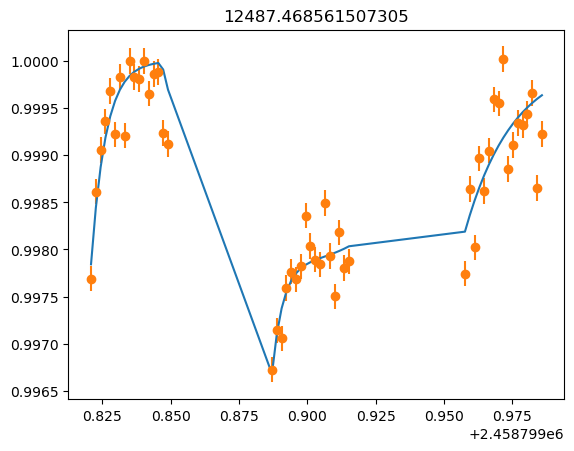

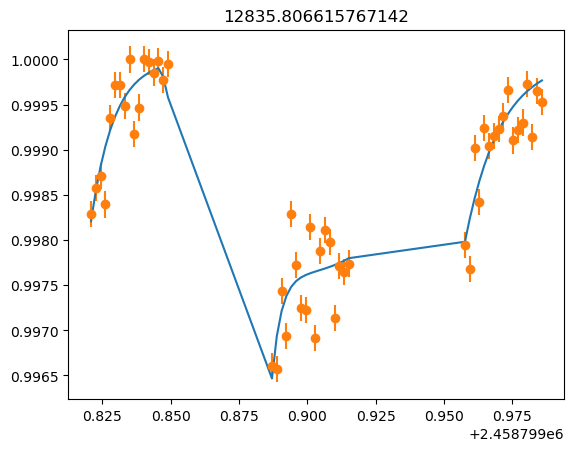

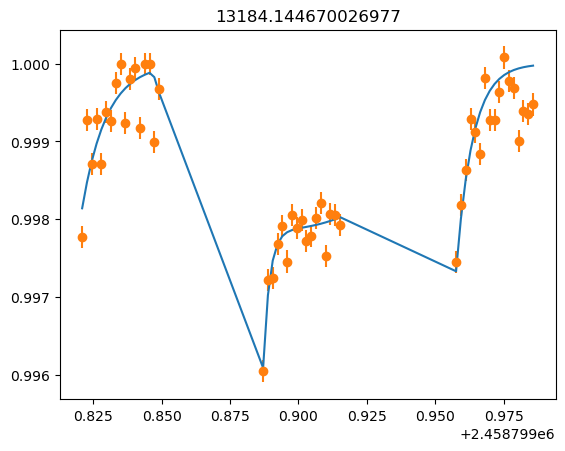

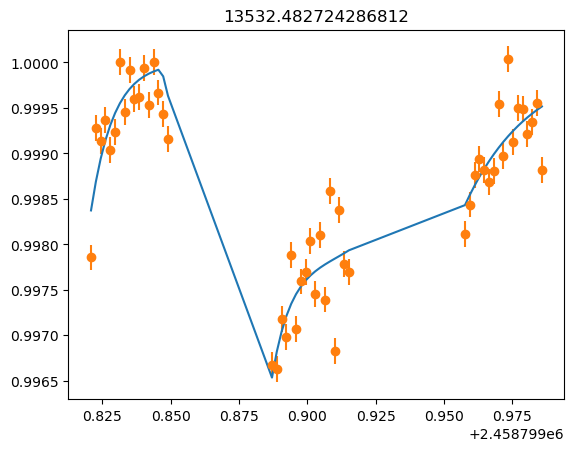

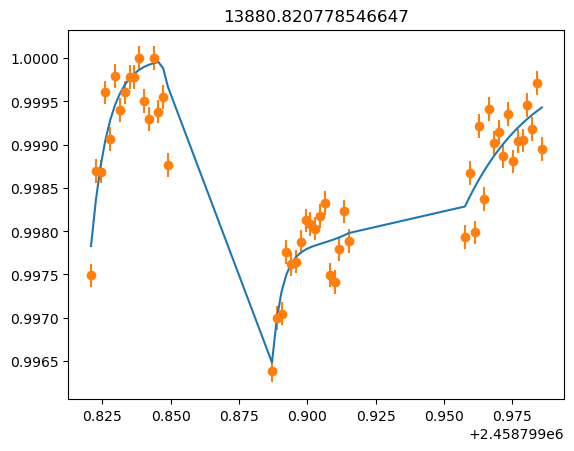

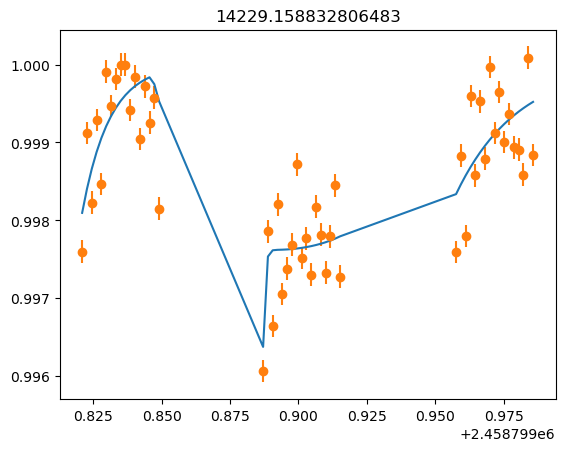

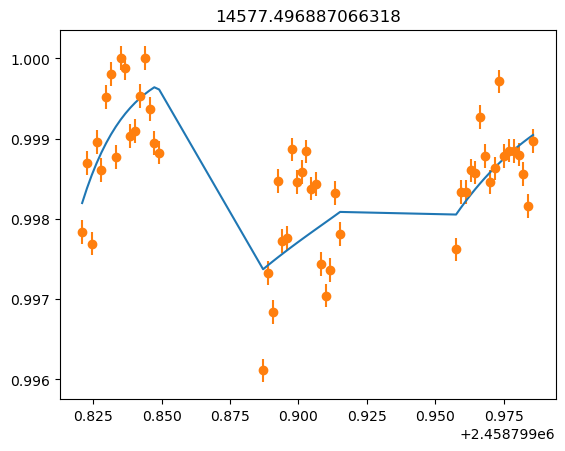

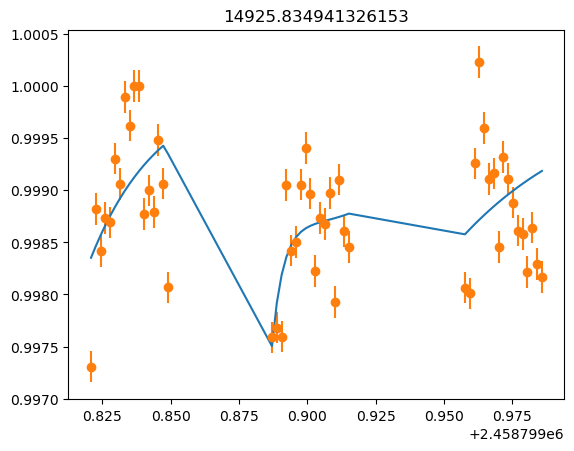

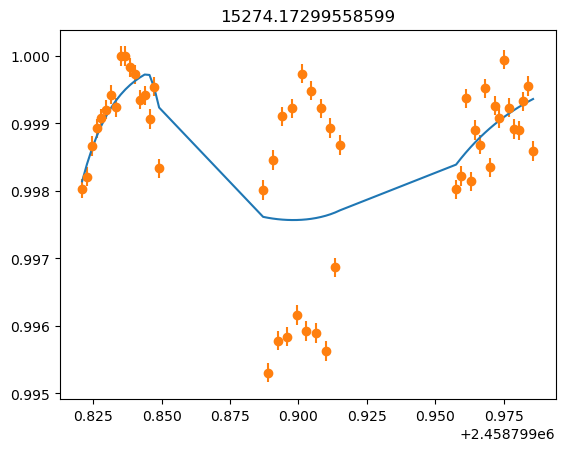

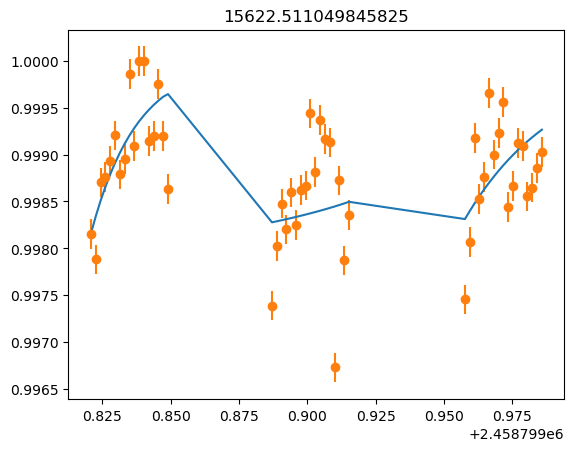

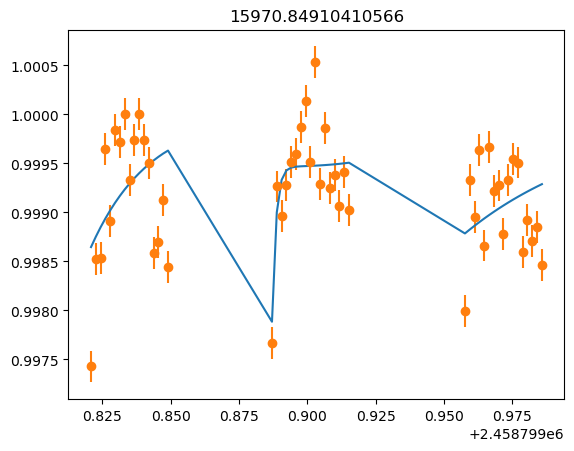

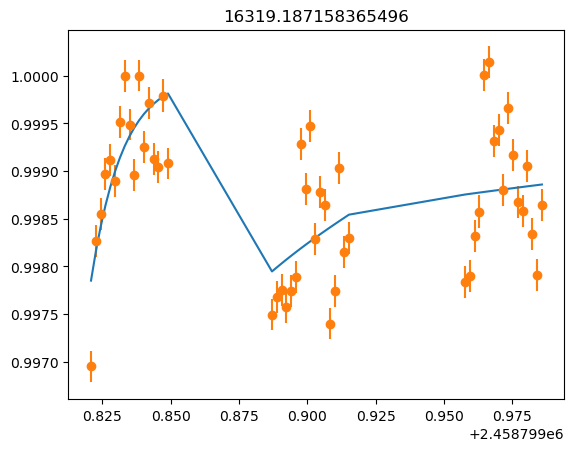

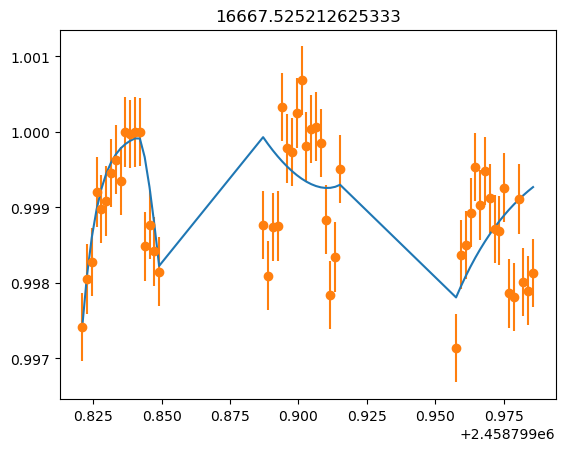

In [33]:
for wav in range(Nwaves):
    tmodel = transit(param_fits[wav], BATMAN_initmodel)
    hmodel = hook(param_fits[Nwaves+(6*wav): Nwaves+(6*wav)+6])
    fullmodel = tmodel*hmodel
    
    plt.plot(times, fullmodel)
    plt.errorbar(times, fluxes[:,wav], errors[:,wav], 
                marker='o', ls='None')
    plt.title(str(waves[wav]))
    plt.show()
    
    

In [34]:
depths = np.zeros(Nwaves)
deptherrs = np.zeros(Nwaves)
for i in range(Nwaves):
    rprs_chain = flatsamples[:,i]
    depth_chain = rprs_chain**2
    
    depthfit = np.median(depth_chain)
    depthue = np.percentile(depth_chain, 84) - depthfit
    depthle = depthfit - np.percentile(depth_chain, 16)
    depth_gausserr = np.mean([depthue, depthle])
    
    depths[i] = depthfit
    deptherrs[i] = depth_gausserr

Mean Transit Depth Uncertainty = 456.7 ppm


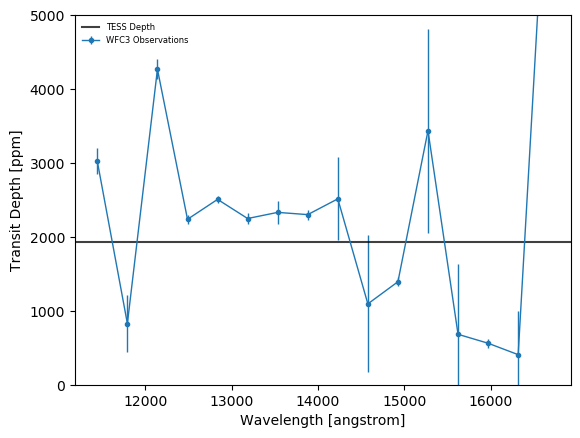

In [35]:
print('Mean Transit Depth Uncertainty = %.1f ppm'%(1.e6*np.mean(deptherrs)))
plt.axhline((rprs_init**2)*1.e6, c='black', alpha=0.75, label='TESS Depth')
plt.errorbar(waves, depths*1.e6, deptherrs*1.e6, 
            lw=1, marker='o', ms=3, label='WFC3 Observations')
plt.xlabel('Wavelength [angstrom]')
plt.ylabel('Transit Depth [ppm]')
plt.ylim((0, 5000))
plt.legend(loc='best', fontsize=6, frameon=False)
plt.show()

In [ ]:

# Generating models with best-fit parameters
bf_transit = transit(param_fits, BATMAN_initmodel)
bf_hook = hook(param_fits)
bf_model = bf_transit * bf_hook

detflux = fluxes / bf_hook
deterrs = errors / bf_hook

# Generating a smooth transit light curve with best-fit parameters for plotting purposes
times_smooth = np.linspace(times[0], times[-1], 100)
BFParams = batman.TransitParams()
BFParams.t0 = param_fits[0]      
BFParams.per = 10.**param_fits[1]
BFParams.a = 10.**param_fits[2]
BFParams.inc = np.arccos(param_fits[3])*(180./np.pi)
BFParams.rp = param_fits[4]
BFParams.ecc = 0.
BFParams.w = 90.
BFParams.limb_dark = 'quadratic'
BFParams.u = [0.33, 0.2]
BATMAN_smoothmodel = batman.TransitModel(BFParams, times_smooth)
transit_smooth = transit(param_fits, BATMAN_smoothmodel)

In [ ]:
#cornerfig = corner.corner(flatsamples, labels=labels, show_titles=True)
#plt.show()

In [ ]:
headers = ["Fit Value", "Upper error", "Lower error"]
l = []
for i, val in enumerate(labels):
    new = [labels[i], param_fits[i], param_uperrs[i], param_loerrs[i]]
    l.append(new)
    
from tabulate import tabulate    
table = tabulate(l, headers, tablefmt='orgtbl')
print('Best-Fit Fitting Parameters')
print(table)

## Computing derived parameters
# transit depth
tdepth_chain = flatsamples[:,4]**2
tdepth_fit = np.median(tdepth_chain)
tdepth_uperr = np.percentile(tdepth_chain, 84) - tdepth_fit
tdepth_loerr = tdepth_fit - np.percentile(tdepth_chain, 16)
# period [day]
P_chain = 10.**(flatsamples[:,1])
P_fit = np.median(P_chain)
P_uperr = np.percentile(P_chain, 84) - P_fit
P_loerr = P_fit - np.percentile(P_chain, 16)

derived_labels = np.asarray(['depth', 'P'])
dp_fits = np.asarray([tdepth_fit, P_fit])
dp_uperrs = np.asarray([tdepth_uperr, P_uperr])
dp_loerrs = np.asarray([tdepth_loerr, P_loerr])
dl = []
for i, val in enumerate(derived_labels):
    dl.append([derived_labels[i], dp_fits[i], dp_uperrs[i], dp_loerrs[i]])
print('Derived Parameters')
table2 = tabulate(dl, headers, tablefmt='orgtbl')
print(table2)

## error statistics
print('Error Statistics')
residuals = fluxes - bf_model
mean_residual = np.mean(abs(residuals))
print('Mean Residual = %.2f ppm'%(mean_residual*1.e6))
mean_dataerr = np.mean(errors)
print('Mean Data Error = %.2f ppm'%(mean_dataerr*1.e6))
mean_deterr = np.mean(deterrs)
print('Mean Detrended Error = %.2f ppm'%(mean_deterr*1.e6))
bf_lnPost = lnPosterior(param_fits)
print('Best Fit lnPosterior = ', bf_lnPost)

In [ ]:
# bf_lnPost = lnPosterior(param_fits)
# print('ln Posterior values:')
# print('init = ', lnPost_init)
# print('best fit = ', bf_lnPost)
# #print('ratio = ', abs(bf_lnPost)/abs(lnPost_init))

# print('error statistics')
# print('mean detrended uncertainty = ', 1.e6*np.mean(deterrs), ' ppm')

# print('mean absolute residual = ', 1.e6*np.mean(abs(residuals)), ' ppm')

# fig, ax = plt.subplots(figsize=(8, 8), nrows=3, sharex=True)
# plt.subplots_adjust(hspace=0.1)
# ax[0].plot(times, bf_model, c='black', alpha=0.75, label='Best Fit Model')
# ax[0].scatter(times, fluxes, c='blue', zorder=5, s=5, label='Observed Data')
# ax[0].legend(loc='best', fontsize=8, frameon=False)
# ax[0].set_ylim(0.995, 1.001)
# ax[0].set_ylabel('Norm. Flux')

# ax[1].plot(times_smooth, transit_smooth, c='black', alpha=0.75, label='Best Fit Transit Model')
# ax[1].scatter(times, detflux, c='blue', zorder=5, s=3, label='Detrended Data')
# ax[1].legend(loc='best', fontsize=8, frameon=False)
# ax[1].set_ylabel('Norm. Flux')

# ax[2].scatter(times, residuals*1.e6, c='blue', label='Residuals')
# ax[2].axhline(0., c='black', alpha=0.5)
# ax[2].set_ylabel('Residuals [ppm]')
# ax[2].set_ylim(-500, 500)
# ax[2].set_xlabel('Time [BJD TDB]')
# ax[2].legend(loc='best', fontsize=8, frameon=False)

# plt.show()